You can find the main story that goes with the code developed below [right here](http://mimsy.io/sinclair_1_3.html).

## Sinclair Station Exploration

In this JUPYTER notebook, we'll be cleaning and analyzing a small dataset scraped from Wikipedia. This dataset contains information about stations owned by the Sinclair Broadcasting Group, how these stations are spread throughout the United States, and how this distribution has changed over time.

For the remainder of this notebook, I'll assume that the current working directory is a clone of [this github repo](https://github.com/theMimsy/Blog---Sinclair-Broadcast-Group).

To analyze this data, we'll first load some libraries that we'll need throughout the notebook. These include libraries for basic join/merge commands as well as mapping and plotting libraries for producing our final visualizations.

+ `dplyr`: Used for `group_by()`, `filter()`, `summarize()`, and `mutate()` functions.
+ `maps`: A very simple R library containing outlines of the USA and USA states. Although we won't be using these, this library also contains world maps, locations of large US cities, and the locations of large world cities.
+ `ggplot2`: A flexible plotting tool that generates graphics using a [layered grammar of graphics](http://byrneslab.net/classes/biol607/readings/wickham_layered-grammar.pdf). If you want to know more, I'd recommend spending a bit of time reading through chapters 1 and 2 in [Hadley Wickham's ggplot2 book](http://ms.mcmaster.ca/~bolker/misc/ggplot2-book.pdf).
+ `RColorBrewer`: Pretty colors for our graphs.

In [1]:
# Load up some libraries
library(dplyr, warn.conflicts = FALSE)
library(maps)
library(ggplot2)
library(RColorBrewer)

### The Scraped Data

All of the custom data we will be working with for this notebook exists under the `Scraper/sinclair_stations.csv` and `Scraper/sinclair_stations_previous.csv` files. I collected this data from the following URL:

[Sinclair Group Stations](https://en.wikipedia.org/wiki/List_of_stations_owned_or_operated_by_Sinclair_Broadcast_Group)

A quick disclaimer: I scraped *some* of the data (the columns labeled `Location` and `Power`) by following links present in the original URL, not from the actual page itself. To see the (admittedly incomplete) module/script used to extract the data, have a look-see at `Scraper/scrape_wiki.py` and `Scraper/wikitable.py`.

For the first part of this notebook, we'll be exploring and cleaning the data present in the two csvs mentioned above. `sinclair_stations.csv` contains information on all stations *currently* owned or operated by Sinclair. This is in contrast to `sinclair_stations_previous.csv` which contains information on stations that were *previously* owned or operated by Sinclair but are now under different management.

#### Cleaning up the Data

Now that we have a little bit of information on what's to come, lets load up both of these csv files into R, clean them up a bit, and create some nice visualizations.

First up, we have `sinclair_stations.csv`:

In [2]:
sinclair_station_path <- "Scraper/sinclair_stations.csv"
sinclair_station_df <- read.csv(sinclair_station_path, stringsAsFactors = FALSE)
sinclair_station_df <- sinclair_station_df[, c(1, 2, 3, 4, 9, 10, 11, 12)]

In [3]:
head(sinclair_station_df)

Market,Station,Channel.RF.,Year,Power,Location,Latitude,Longitude
"Birmingham - Tuscaloosa - Anniston, AL",WTTO,21 (28),1995,765 kW,33.484583; -86.807083,33.48458,-86.80708
"Birmingham - Tuscaloosa - Anniston, AL",WABM,68 (36),2001,885 kW,33.484583; -86.807056,33.48458,-86.80706
"Birmingham - Tuscaloosa - Anniston, AL",WDBB,17 (18),1995,,,NA,NA
"Birmingham - Tuscaloosa - Anniston, AL",WBMA-LD,58 (40),2014,,See table below,NA,NA
"Mobile, AL & Pensacola, FL",WEAR-TV,3 (17),1997,"1,000 kW",30.612611; -87.644889,30.61261,-87.64489
"Mobile, AL & Pensacola, FL",WPMI-TV,15 (15),2012,1000 kW,30.61139; -87.607333,30.61139,-87.60733


There are a couple of things to notice in the code and results above.

First, I specifically skipped over columns 5-8 when reading the csv. These columns contain information on the DT affiliations (FOX, CBS, NBC, etc.) of each station that I thought might be useful in future research but that are not going to be useful to us today.

Second, some rows are missing information under the `Location` and `Power` columns. Missing information occured because of two reasons: the information was actually missing (station WDBB), or the information was moved to a non-standard location on the wikipedia page (this is the case for station WBMA-LD). Instead of shaming me on creating a bad web-scraper, lets just manually fill in the stations that I originally missed.

In [4]:
# Columns to fill and column to select by
fill_cols <- c("Power", "Location", "Latitude", "Longitude")
select_col <- sinclair_station_df$Station

# Manual labor :(
sinclair_station_df[select_col == "WBMA-LD", fill_cols] <- 
    c("885 kW", "33.484583; -86.807056", 33.484583, -86.807056)
sinclair_station_df[select_col == "WWHB-CA", fill_cols] <- 
    c("", "27.025222; -80.178528", 27.025222, -80.178528)
sinclair_station_df[select_col == "KECI-TV", fill_cols] <- 
    c("30 kW", "47.017250; -114.014056", 47.017250, -114.014056)
sinclair_station_df[select_col == "KCFW-TV", fill_cols] <- 
    c("2.5 kW", "48.01333; -114.36639", 48.01333, -114.36639)
sinclair_station_df[select_col == "KTVM-TV", fill_cols] <- 
    c("11.2 kW", "46.00750; -112.44250", 46.00750, -112.44250)
sinclair_station_df[select_col == "KDBZ-CD", fill_cols] <- 
    c("15 kW", "45.67333; -110.86722", 45.67333, -110.86722)

# Make sure that Latitude and Longitude are still numeric columns
sinclair_station_df[c("Latitude", "Longitude")] <- sapply(
    sinclair_station_df[c("Latitude", "Longitude")], as.numeric)

In [5]:
head(sinclair_station_df)

Market,Station,Channel.RF.,Year,Power,Location,Latitude,Longitude
"Birmingham - Tuscaloosa - Anniston, AL",WTTO,21 (28),1995,765 kW,33.484583; -86.807083,33.48458,-86.80708
"Birmingham - Tuscaloosa - Anniston, AL",WABM,68 (36),2001,885 kW,33.484583; -86.807056,33.48458,-86.80706
"Birmingham - Tuscaloosa - Anniston, AL",WDBB,17 (18),1995,,,NA,NA
"Birmingham - Tuscaloosa - Anniston, AL",WBMA-LD,58 (40),2014,885 kW,33.484583; -86.807056,33.48458,-86.80706
"Mobile, AL & Pensacola, FL",WEAR-TV,3 (17),1997,"1,000 kW",30.612611; -87.644889,30.61261,-87.64489
"Mobile, AL & Pensacola, FL",WPMI-TV,15 (15),2012,1000 kW,30.61139; -87.607333,30.61139,-87.60733


This looks better but we still have some missing data. How much?

In [6]:
total <- nrow(sinclair_station_df)
missing_power <- 
    sum(is.na(sinclair_station_df$Power) | sinclair_station_df$Power == "")
missing_location <- 
    sum(is.na(sinclair_station_df$Location) | sinclair_station_df$Location == "")

print(paste("Missing Power   ", missing_power, "/", total))
print(paste("Missing Location", missing_location, "/", total))

[1] "Missing Power    22 / 190"
[1] "Missing Location 25 / 190"


While it might seem alarming that we're missing more than 10% of our data, after looking into the missing values I found that most corresponded to satellite versions of stations that do *not* have missing values. For example, the station WDBB (which has missing values) is just a satellite version of the station WTTO (which does not have missing values). With this in mind, we safely ignore the missing values and continue the analysis.

One last bit of cleanup work to do for our first csv file: we need to convert the `Power` column from character to numeric values. While its informative that we have units for each station/transmitter, it would be a lot more useful to just have this as a numeric column. We can put the units in the column name.

In [7]:
sinclair_station_df$Power <- 
    sub(" kW", "", sinclair_station_df$Power)   # Remove units
sinclair_station_df$Power <- 
    sub(",", "", sinclair_station_df$Power)     # Remove commas
sinclair_station_df$Power <- 
    as.numeric(sinclair_station_df$Power)       # Convert to numeric values
colnames(sinclair_station_df)[5] <- "Power.kW"  # Change column name

Don't worry, I made sure all of the rows were given in "kW" so I didn't have to check for other units like "MW" or "W".

In [8]:
head(sinclair_station_df)

Market,Station,Channel.RF.,Year,Power.kW,Location,Latitude,Longitude
"Birmingham - Tuscaloosa - Anniston, AL",WTTO,21 (28),1995,765,33.484583; -86.807083,33.48458,-86.80708
"Birmingham - Tuscaloosa - Anniston, AL",WABM,68 (36),2001,885,33.484583; -86.807056,33.48458,-86.80706
"Birmingham - Tuscaloosa - Anniston, AL",WDBB,17 (18),1995,NA,,NA,NA
"Birmingham - Tuscaloosa - Anniston, AL",WBMA-LD,58 (40),2014,885,33.484583; -86.807056,33.48458,-86.80706
"Mobile, AL & Pensacola, FL",WEAR-TV,3 (17),1997,1000,30.612611; -87.644889,30.61261,-87.64489
"Mobile, AL & Pensacola, FL",WPMI-TV,15 (15),2012,1000,30.61139; -87.607333,30.61139,-87.60733


Now, let's move onto cleaning up the second csv file `sinclair_stations_previous.csv`. This file basically contains the same information as the first, except that the `Year` column is now a character column with two dates: the start date and the end date.

In [9]:
sinclair_station_prev_path <- "Scraper/sinclair_stations_previous.csv"
sinclair_station_prev_df <- read.csv(sinclair_station_prev_path, stringsAsFactors = FALSE)
sinclair_station_prev_df <- sinclair_station_prev_df[, c(1, 2, 3, 4, 6, 7, 8, 9)]

In [10]:
head(sinclair_station_prev_df)

Market,Station,Channel.RF.,Year,Power,Location,Latitude,Longitude
"Anniston, AL",WJSU-TV,40 (9),2014-2015,,,NA,NA
"Tuscaloosa, AL",WCFT-TV,33 (33),2014-2015,,,NA,NA
"Stockton - Sacramento, CA",KOVR,13 (25),1997-2005,"1,000 kW",38.24000; -121.50083,38.24000,-121.50083
"Colorado Springs - Pueblo, CO",KXRM-TV,21 (22),2013-2014,51 kW,38.745389; -104.860889,38.74539,-104.86089
"Colorado Springs - Pueblo, CO",KXTU-LD,57 (20),2013-2014,,,NA,NA
St. Petersburg - Tampa,WTTA,38 (32),1991-2014,"1,000 kW",27.84250; -82.262528,27.84250,-82.26253


Good news and bad news. 

Good news: this time around the web-scraper didn't miss any information! All of the missing values you see above actually don't exist on Wikipedia. 

Bad news: out of 27 rows of data, 7 of them have missing `Location` and `Power` information. Since I will be combining this dataset with the previous one, this missing data isn't the end of the world, but it may be worth it to independently chase it down if someone has time.

Now, we will do the same `Power` transformation that we did on the previous file.

In [11]:
sinclair_station_prev_df$Power <- 
    sub(" kW", "", sinclair_station_prev_df$Power)  # Remove units
sinclair_station_prev_df$Power <- 
    sub(",", "", sinclair_station_prev_df$Power)    # Remove commas
sinclair_station_prev_df$Power <- 
    as.numeric(sinclair_station_prev_df$Power)      # Convert to numeric
colnames(sinclair_station_prev_df)[5] <- "Power.kW" # Change column name

In [12]:
head(sinclair_station_prev_df)

Market,Station,Channel.RF.,Year,Power.kW,Location,Latitude,Longitude
"Anniston, AL",WJSU-TV,40 (9),2014-2015,NA,,NA,NA
"Tuscaloosa, AL",WCFT-TV,33 (33),2014-2015,NA,,NA,NA
"Stockton - Sacramento, CA",KOVR,13 (25),1997-2005,1000,38.24000; -121.50083,38.24000,-121.50083
"Colorado Springs - Pueblo, CO",KXRM-TV,21 (22),2013-2014,51,38.745389; -104.860889,38.74539,-104.86089
"Colorado Springs - Pueblo, CO",KXTU-LD,57 (20),2013-2014,NA,,NA,NA
St. Petersburg - Tampa,WTTA,38 (32),1991-2014,1000,27.84250; -82.262528,27.84250,-82.26253


To finish the cleanup, we separate out the start and end dates from the `Year` column and split them out into their own. It helps that (almost) every entry is given in `<year>-<year>` form; it makes it much easier to extract. 

There are a few entries that only show one year. This implies that Sinclair only owned that station for a single year before selling it. We can handle this by setting the end date equal to the start date.

In [13]:
# Separate start and end dates
sinclair_station_prev_df$Year.Start <- 
    substr(sinclair_station_prev_df$Year, 1, 4) # First 4 characters
sinclair_station_prev_df$Year.End <- 
    substr(sinclair_station_prev_df$Year, 6, 9) # Last 4 characters

# Some stations were only owned for a year so only one piece of data was listed
# Take care of this by creating a mask and copying over the right values
one_year_mask <- sinclair_station_prev_df$Year.End == ""
sinclair_station_prev_df$Year.End[one_year_mask] <- 
    sinclair_station_prev_df$Year.Start[one_year_mask]

# Remember to conver to numeric
sinclair_station_prev_df[c("Year.Start", "Year.End")] <- 
    sapply(sinclair_station_prev_df[c("Year.Start", "Year.End")], as.numeric)

In [14]:
sinclair_station_prev_df[
    c("Market", "Station", "Year", "Power.kW", 
      "Latitude", "Longitude", "Year.Start", "Year.End")]

Market,Station,Year,Power.kW,Latitude,Longitude,Year.Start,Year.End
"Anniston, AL",WJSU-TV,2014-2015,NA,NA,NA,2014,2015
"Tuscaloosa, AL",WCFT-TV,2014-2015,NA,NA,NA,2014,2015
"Stockton - Sacramento, CA",KOVR,1997-2005,1000.0,38.24000,-121.50083,1997,2005
"Colorado Springs - Pueblo, CO",KXRM-TV,2013-2014,51.0,38.74539,-104.86089,2013,2014
"Colorado Springs - Pueblo, CO",KXTU-LD,2013-2014,NA,NA,NA,2013,2014
St. Petersburg - Tampa,WTTA,1991-2014,1000.0,27.84250,-82.26253,1991,2014
"Tallahassee, FL - Thomasville, GA",WTXL-TV,2001-2006,1000.0,30.66833,-83.96944,2001,2006
Idaho Falls - Pocatello,KIDK,2013,200.0,43.49739,-112.66464,2013,2013
Idaho Falls - Pocatello,KXPI-LD,2013,5.2,42.86611,-112.51333,2013,2013
Bloomington - Indianapolis,WIIB,1988-1997,NA,NA,NA,1988,1997


#### Merging the Datasets

Now that we finished the cleanup of both csv files, we are almost ready to get on to the fun part: analysis! However, our life will be much easier once we start plotting if we first combine both datasets into one large one. 

This is pretty simple to do; we'll just add the `Year.Start` and `Year.End` columns to the `sinclair_stations_df` so that it looks like `sinclair_stations_prev_df`. "But the stations in the first dataset don't have end dates!", you say. Well, we can just give all those stations the value `NA` for their `Year.End` column. It's important to remember that we've done this, however, so that we correctly set the limits on our graphs later.

In [15]:
# Add start and end dates to our first dataset
sinclair_station_df$Year.Start <- sinclair_station_df$Year
sinclair_station_df$Year.End <- NA

# Concatenate the datasets
sinclair_station_all_df <- rbind(sinclair_station_df, sinclair_station_prev_df)

In [16]:
head(sinclair_station_all_df)

Market,Station,Channel.RF.,Year,Power.kW,Location,Latitude,Longitude,Year.Start,Year.End
"Birmingham - Tuscaloosa - Anniston, AL",WTTO,21 (28),1995,765,33.484583; -86.807083,33.48458,-86.80708,1995,NA
"Birmingham - Tuscaloosa - Anniston, AL",WABM,68 (36),2001,885,33.484583; -86.807056,33.48458,-86.80706,2001,NA
"Birmingham - Tuscaloosa - Anniston, AL",WDBB,17 (18),1995,NA,,NA,NA,1995,NA
"Birmingham - Tuscaloosa - Anniston, AL",WBMA-LD,58 (40),2014,885,33.484583; -86.807056,33.48458,-86.80706,2014,NA
"Mobile, AL & Pensacola, FL",WEAR-TV,3 (17),1997,1000,30.612611; -87.644889,30.61261,-87.64489,1997,NA
"Mobile, AL & Pensacola, FL",WPMI-TV,15 (15),2012,1000,30.61139; -87.607333,30.61139,-87.60733,2012,NA


As a sanity check, make sure that all of the columns in our data have the expected types.

In [17]:
sapply(sinclair_station_all_df, class)

Market     Station Channel.RF.        Year    Power.kW    Location 
"character" "character" "character" "character"   "numeric" "character" 
   Latitude   Longitude  Year.Start    Year.End 
  "numeric"   "numeric"   "numeric"   "numeric"

Looks good. We'll be using `Latitude`, `Longitude`, `Year.Start`, `Year.End`, and `Power.kW` in our plots so its important that these columns are numeric.

Of course, we don't want all our hard work to go to waste so we'll also save the merged dataframe into a csv file.

In [18]:
sinclair_station_all_path <- "sinclair_station_all.csv"
write.csv(sinclair_station_all_df, file = sinclair_station_all_path, row.names = FALSE)


Now, lets get to graphing!

### Graph and Analyze

We have two questions that we want to answer in this notebook:

1. How has the number of stations owned/operated by Sinclair changed over time?
2. How does the spread of stations look like spatially, from the viewpoint of the US as a whole?

#### Stations vs Time

Unsurprisingly, we'll tackle question **1** first.

Since we've already done the hard part of getting a coherent dataframe together, this will be pretty easy to do. We'll just look at every year between the minimum and maximum years in our dataset; for each of these years we'll count up all stations owned by Sinclair and substract the stations that they've sold off. Finally, we'll take this data and present it in a tidy line graph.

The code below generates the data we want:

In [19]:
# Get temporal limits of the data
max_year <- max(sinclair_station_all_df$Year.Start, na.rm = TRUE)
min_year <- min(sinclair_station_all_df$Year.Start, na.rm = TRUE)

# Get rid of data that has missing year values
no_na_year_df <- sinclair_station_all_df %>% filter(!is.na(Year.Start))

# Create aliases for the two year columns
start_year <- no_na_year_df$Year.Start
end_year <- no_na_year_df$Year.End

# Make a new data.frame and fill it using a for-loop
# This is a slow way to do it but our dataset is not huge 
station_count_df <- data.frame()
for(year in min_year:max_year) {
    # Generate the station count
    # Remember to take care of possible NA values in `end_year`
    new_row <- c(year, sum(start_year <= year & (end_year >= year | is.na(end_year))) )
    station_count_df <- rbind(station_count_df, new_row)
}
colnames(station_count_df) <- c("Year", "Station.Count")

Here's a random unordered sample of years just to see what the output looks like.

In [20]:
station_count_df[sample(1:nrow(station_count_df), 5),]

,Year,Station.Count
9,1979,1
23,1993,5
2,1972,1
5,1975,1
38,2008,54


Now, we use my favorite plotting library (`ggplot2` in case you were wondering) to visualize this data.

In [21]:
# Set the size of output graphics
library(repr)
options(repr.plot.width=8, repr.plot.height=5)

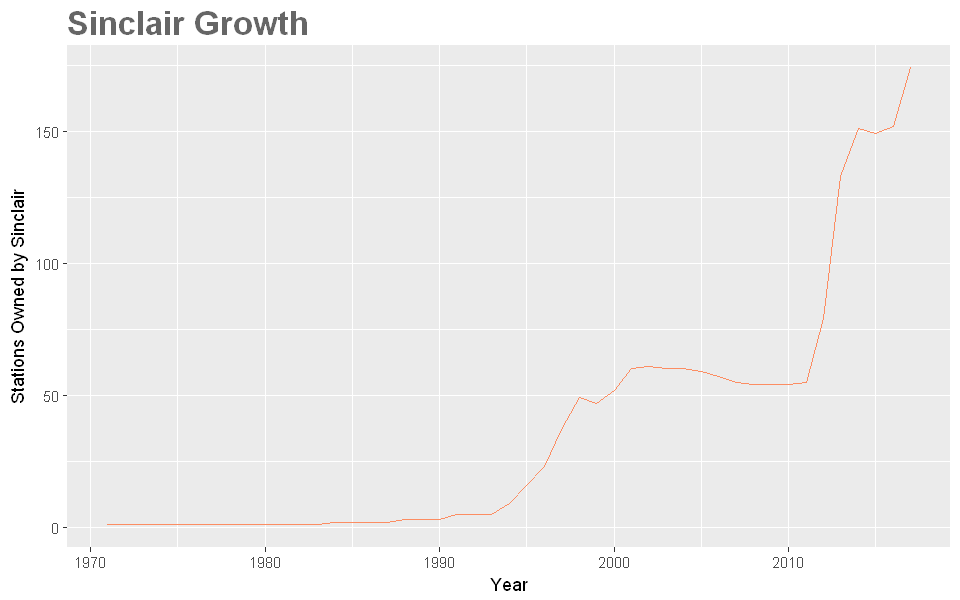

In [22]:
# Create the plot
sinclair_growth_plot <- ggplot(data = station_count_df) +
    geom_line(aes(x = Year, y = Station.Count), color = brewer.pal(3, "Set2")[2]) + 
    ggtitle("Sinclair Growth") + 
    xlab("Year") + 
    ylab("Stations Owned by Sinclair") +
    theme(plot.title = element_text(color="#666666", face="bold", size=20))

sinclair_growth_plot

Yup, that's a healthy looking business! We can see that their real growth started during the mid 1990s (a few small acquisitions), dropped a little bit in the late 2000s (not really good times for anyone), but skyrocketed after late 2011-2012.

We can also see from the chart the global maximum is the last datapoint (2017). What exactly is this number?

In [23]:
max(station_count_df$Station.Count)

[1] 174

Starting from just a single tower, Sinclair has done well for itself! As of 2017 they've grown to own or operate 174 stations.

#### Stations vs USA

Now that we've had a good idea of how fast the Sinclair Group has grown, we need to answer question **2** and take a look at *where* in the US that growth has occured.

To do this, we'll once again use `ggplot2`. To anyone with a background in GIS (Geographic Information Systems), they might find it useful to know that I'll be using the Albers projection optimized for viewing the USA (`lat0 = 37.5, lat1 = 29.5`).

After creating a simple plot of the USA, I'll use the layers feature of `ggplot2` to add markers of each station on top. The size of each station marker will correspond to the `Power` of that station. I decided that the best way to visualize the spread of Sinclair stations is by looking at "snapshots" of stations during every year. This means that I'll create a different map for every year in the dataset and plot the stations owned during that year.

Onto the code! Before getting to `ggplot2` we'll have to filter out any missing data from `sinclair_station_all_df` and get the spatial coordinates for drawing a map of the USA.

In [24]:
# Get USA spatial data
usa_map_df <- map_data("usa")     # Tells ggplot2 how to plot outline of the US
state_map_df <- map_data("state") # Tells ggplot2 how to plot outlines of each US state

# Extract only that station data that we'll need for plotting
sinclair_final_df <- sinclair_station_all_df[c("Station", "Power.kW", "Latitude",
                                                 "Longitude", "Year.Start", "Year.End")]

# Get rid of rows that don't have the necessary data
has_location <- !is.na(sinclair_final_df$Latitude) & !is.na(sinclair_final_df$Longitude)
has_power <- !is.na(sinclair_final_df$Power)
has_start <- !is.na(sinclair_final_df$Year.Start)
sinclair_final_df <- sinclair_final_df[has_location & has_power & has_start,]

In [25]:
head(sinclair_final_df)

,Station,Power.kW,Latitude,Longitude,Year.Start,Year.End
1,WTTO,765,33.48458,-86.80708,1995,NA
2,WABM,885,33.48458,-86.80706,2001,NA
4,WBMA-LD,885,33.48458,-86.80706,2014,NA
5,WEAR-TV,1000,30.61261,-87.64489,1997,NA
6,WPMI-TV,1000,30.61139,-87.60733,2012,NA
7,WFGX,1000,30.61261,-87.64489,2001,NA


Since I'll be plotting the stations owned by Sinclair for every year in the dataset, it would be best to put all of the necessary code into one function that takes the `year` as its only argument. This function will separate the data in `sinclair_final_df` by the given `year` variable and label it appropriately. It will then filter out the stations not currently owned and graph the remaining ones on top of a map of the US. The code is quite involved, but I hope the comments make it easy to read.

In [26]:
plot_sinclair_stations <- function(year) {
    
    # Separate the spatial data into four datasets
    # The output is a dataframe with an additional column that labels a particular
    # station as either "acquired this year", "sold this year",
    # "acquired previous years", or "not held".
    final_spatial_df <- sinclair_final_df %>%
        mutate(Acquired = case_when(
            (Year.Start < year) & (Year.End > year | is.na(Year.End)) ~ 
                "acquired\nprevious years",
            Year.Start == year ~ "acquired\nthis year",
            Year.End == year ~ "sold\nthis year",
            TRUE ~ "not held")
        )
    
    # We don't want to show the station that were not held during the given year
    # Filter out unwanted stations using a mask
    held_mask <- final_spatial_df$Acquired != "not held"
    final_spatial_df <- final_spatial_df[held_mask, ]
    factor_levels <- c("acquired\nprevious years", "acquired\nthis year", "sold\nthis year")
    final_spatial_df$Acquired <- factor(final_spatial_df$Acquired, levels = factor_levels)

    # Pick some nice colors
    nice_colors <- brewer.pal(3, "Set2")
    
    # Make the plot
    ggplot() +
        # Set the projection to USA-Albers
        coord_map("albers", lat0 = 37.5, lat1 = 29.5) + 
        # Graph the outline of the US
        geom_polygon(data = usa_map_df,
                     aes(x = long, y = lat, group = group),
                     color = "gray60") +
        # Graph the outline of each state
        geom_polygon(data = state_map_df,
                     aes(x = long, y = lat, group = group),
                     color = "gray60") +
        # Graph the location of each station
        geom_point(data = final_spatial_df,
                   aes(x = Longitude, y = Latitude, size = Power.kW, color = Acquired),
                   alpha = 0.75) +
        # Set size/radius and color of the station markers
        scale_radius(limits = c(0, 1000)) +
        scale_color_manual(values = nice_colors, drop = FALSE) +
        # Set the title, colors, legend position and other thematic options
        theme(plot.title = element_text(hjust = 0.1, color="#666666", face="bold", size=20), 
            axis.text = element_blank(), 
            axis.line = element_blank(), 
            axis.ticks = element_blank(),
            axis.title = element_blank(),
            panel.border = element_blank(),
            legend.position = c(0.93, 0.5),
            legend.key.size = unit(1, "cm"),
            legend.text = element_text(size=12),
            legend.title = element_text(size=12),
            panel.grid = element_blank(),
            panel.background = element_blank()) +
        guides(size=guide_legend(title="Transmitter\nPower (kW)"), byrow = TRUE) +
        ggtitle(paste("Sinclair Stations in", year))
}

Phew! Now to test out our function. I know from looking at the data that there was a lot of action during the year 2013. Lets use this year as our test date.

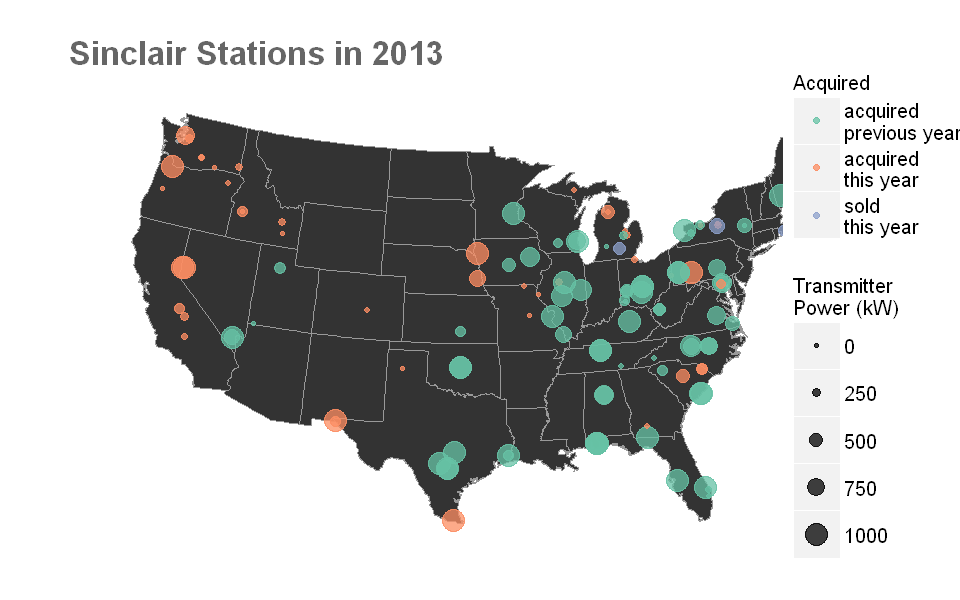

In [27]:
plot_sinclair_stations(2013)

Hey, not bad! In case you're wondering why the legend is so large, that was done on purpose. It might look wonky in this JUPYTER notebook, but this legend size looks perfect (in my opinion) when each image is saved as a png.

Speaking of which, we just need to save our images and then we're done! The last bit of code that will do this needs to loop through every year and create an image like the one above. Later, I'll stitch the images together into one gif so that we can observe how Sinclair stations have spread from the east coast to the west throughout the last several years. We'll also save our earlier *Sinclair Growth* plot as well.

In [28]:
IMAGE_OUTPUT_PATH <- "Images"

In [29]:
# Don't forget to save our earlier graph
ggsave(filename = 'Sinclair_Growth.png', 
    plot = sinclair_growth_plot,
    path = IMAGE_OUTPUT_PATH,
    width = unit(8, "cm"),
    height = unit(5, "cm"))

In [30]:
# Get the limits on the years
max_year <- max(sinclair_final_df$Year.Start, na.rm = TRUE)
min_year <- min(sinclair_final_df$Year.Start, na.rm = TRUE)

# Loop through each year, generate a plot, and save that plot.
for(year in min_year:max_year) {
    image <- plot_sinclair_stations(year)
    image.name <- paste("Sinclair_Stations", year, sep = "_")
    image.name <- paste(image.name, ".png", sep = "")
    ggsave(filename = image.name, 
        plot = image,
        path = IMAGE_OUTPUT_PATH,
        width = unit(14, "cm"),
        height = unit(10, "cm"))
}

Finished! =)